# London Smart meters dataset

https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

## Transform extracting features with TSFEL

In [47]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

In [48]:
import tsfel

In [49]:
DATASET_ID = 0 # 'FULL'
DECIMATION_RATE = 0.1 # valid only if dataset is FULL

In [50]:
def diff_min( s : pd.Series ) -> float :
    return s.diff().min()

def diff_max( s : pd.Series ) -> float :
    return s.diff().max()

def q25( s : pd.Series ) -> float :
    return s.quantile( 0.25 )

def q50( s : pd.Series ) -> float :
    return s.quantile( 0.50 )

def q75( s : pd.Series ) -> float :
    return s.quantile( 0.75 )

In [51]:
dataset_root = Path('../../Dataset')

In [52]:
if isinstance( DATASET_ID, int )  :
    dataset = sorted(list((dataset_root/'partitioned/Small LCL Data').glob('*.csv')))[ DATASET_ID ]
else :
    dataset = dataset_root/'full/CC_LCL-FullData.csv'

In [53]:
%%time
df = pd.read_csv(dataset, names = ['ID','type','timestamp','consumption'], header = 0) 

CPU times: user 419 ms, sys: 23.4 ms, total: 442 ms
Wall time: 441 ms


In [54]:
ids = df.ID.unique()
if not isinstance( DATASET_ID, int )  :
    ids = np.random.choice( ids, int( len(ids) * DECIMATION_RATE ) )
    df = df.query( 'ID in @ids' )

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID           1000000 non-null  object
 1   type         1000000 non-null  object
 2   timestamp    1000000 non-null  object
 3   consumption  1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [56]:
%%time
df = (df
      .assign( timestamp = pd.to_datetime(df.timestamp) )
      .assign( consumption = pd.to_numeric( df.consumption, errors = 'coerce' ) )
      .assign( invalid = lambda x : x.consumption.isna() )
#      .assign( consumption = lambda x : x.consumption.fillna( -1.0 ) )
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   ID           1000000 non-null  object        
 1   type         1000000 non-null  object        
 2   timestamp    1000000 non-null  datetime64[ns]
 3   consumption  999971 non-null   float64       
 4   invalid      1000000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(2)
memory usage: 31.5+ MB
CPU times: user 397 ms, sys: 23.8 ms, total: 421 ms
Wall time: 419 ms


In [57]:
df.tail()

,ID,type,timestamp,consumption,invalid
999995,MAC000036,Std,2012-11-08 08:00:00,0.228,False
999996,MAC000036,Std,2012-11-08 08:30:00,0.042,False
999997,MAC000036,Std,2012-11-08 09:00:00,0.076,False
999998,MAC000036,Std,2012-11-08 09:30:00,0.070,False
999999,MAC000036,Std,2012-11-08 10:00:00,0.005,False


In [155]:
%%time
df_series = (  df
               .assign( year = df.timestamp.dt.year.astype( str ) )
               .assign( month = df.timestamp.dt.month.apply( lambda d : f'{d:02d}' ) ) 
               .assign( day = df.timestamp.dt.day.apply( lambda d : f'{d:02d}' ) ) 
               .assign( time = df.timestamp.dt.time.astype( str ) )
               .assign( year_month = lambda x : x.year.str.cat( x.month, sep = '-' ) )
               .assign( day_time = lambda x : x.day.str.cat( x.time, sep = '-' ) )
               .assign( sample_name = lambda x : x.ID.str.cat( x.year_month, sep = '-' ) )
               [['sample_name','day_time','consumption']]
               .groupby( ['sample_name','day_time'] )
               .sum()
               .unstack( 'day_time' )             
            )


CPU times: user 3.12 s, sys: 334 ms, total: 3.45 s
Wall time: 3.45 s


In [156]:
df_series

consumption                                                  \
day_time          01-00:00:00 01-00:30:00 01-01:00:00 01-01:30:00 01-02:00:00   
sample_name                                                                     
MAC000002-2012-10         NaN         NaN         NaN         NaN         NaN   
MAC000002-2012-11       0.252       0.241       0.230       0.209       0.231   
MAC000002-2012-12       0.215       0.217       0.237       0.204       0.243   
MAC000002-2013-01       0.219       0.241       0.191       0.235       0.182   
MAC000002-2013-02       0.215       0.284       0.313       0.286       0.204   
...                       ...         ...         ...         ...         ...   
MAC000036-2012-07       0.000       0.055       0.029       0.000       0.033   
MAC000036-2012-08       0.000       0.063       0.015       0.000       0.045   
MAC000036-2012-09       0.000       0.045       0.031       0.000       0.016   
MAC000036-2012-10       0.006       0.006       0.052       0.037       0.006   
MAC000036-2012-11       0.060       0.006       0.006       0.019       0.063   

                                                                               \
day_time          01-02:30:00 01-03:00:00 01-03:30:00 01-04:00:00 01-04:30:00   
sample_name                                                                     
MAC000002-2012-10         NaN         NaN         NaN         NaN         NaN   
MAC000002-2012-11       0.193       0.186       0.148       0.183       0.147   
MAC000002-2012-12       0.199       0.237       0.125       0.104       0.115   
MAC000002-2013-01       0.229       0.194       0.201       0.122       0.099   
MAC000002-2013-02       0.269       0.204       0.266       0.216       0.223   
...                       ...         ...         ...         ...         ...   
MAC000036-2012-07       0.050       0.000       0.011       0.065       0.006   
MAC000036-2012-08       0.033       0.000       0.024       0.052       0.000   
MAC000036-2012-09       0.060       0.000       0.000       0.055       0.019   
MAC000036-2012-10       0.006       0.055       0.033       0.006       0.006   
MAC000036-2012-11       0.000       0.000       0.006       0.066       0.006   

                   ...                                                  \
day_time           ... 31-19:00:00 31-19:30:00 31-20:00:00 31-20:30:00   
sample_name        ...                                                   
MAC000002-2012-10  ...       0.346       0.291       0.333       0.368   
MAC000002-2012-11  ...         NaN         NaN         NaN         NaN   
MAC000002-2012-12  ...       0.227       0.228       1.168       0.272   
MAC000002-2013-01  ...       0.194       0.214       1.078       0.227   
MAC000002-2013-02  ...         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
MAC000036-2012-07  ...       0.039       0.095       0.064       0.043   
MAC000036-2012-08  ...       0.044       0.094       0.065       0.050   
MAC000036-2012-09  ...         NaN         NaN         NaN         NaN   
MAC000036-2012-10  ...       0.044       0.073       0.092       0.188   
MAC000036-2012-11  ...         NaN         NaN         NaN         NaN   

                                                                               \
day_time          31-21:00:00 31-21:30:00 31-22:00:00 31-22:30:00 31-23:00:00   
sample_name                                                                     
MAC000002-2012-10       0.951       1.445       0.946       0.305       0.243   
MAC000002-2012-11         NaN         NaN         NaN         NaN         NaN   
MAC000002-2012-12       0.237       0.231       0.263       0.220       0.236   
MAC000002-2013-01       0.250       0.240       0.281       0.248       0.266   
MAC000002-2013-02         NaN         NaN         NaN         NaN         NaN   
...                       ...         ...         ...         .

In [160]:
# build a dataframe as required by tsfel to extract features:
# rows are timestamps and columns are series names
X = df_series.T.droplevel(0).fillna(0)

# uncomment the following to reduce the samples to a subset, to explore results
# choosen_idxs = np.random.choice(len(df_series), size = 15, replace = False)
# X = df_series.iloc[choosen_idxs].T.droplevel(0).fillna(0)

In [161]:
X.head()

sample_name,MAC000002-2012-10,MAC000002-2012-11,MAC000002-2012-12,MAC000002-2013-01,MAC000002-2013-02,MAC000002-2013-03,MAC000002-2013-04,MAC000002-2013-05,MAC000002-2013-06,MAC000002-2013-07,...,MAC000036-2012-02,MAC000036-2012-03,MAC000036-2012-04,MAC000036-2012-05,MAC000036-2012-06,MAC000036-2012-07,MAC000036-2012-08,MAC000036-2012-09,MAC000036-2012-10,MAC000036-2012-11
day_time,,,,,,,,,,,,,,,,,,,,,
01-00:00:00,0.0,0.252,0.215,0.219,0.215,0.483,0.069,0.226,0.214,0.156,...,0.000,0.008,0.024,0.004,0.040,0.000,0.000,0.000,0.006,0.060
01-00:30:00,0.0,0.241,0.217,0.241,0.284,0.339,0.140,0.186,0.263,0.111,...,0.000,0.003,0.000,0.000,0.053,0.055,0.063,0.045,0.006,0.006
01-01:00:00,0.0,0.230,0.237,0.191,0.313,0.299,0.068,0.207,0.235,0.110,...,0.001,0.027,0.000,0.032,0.000,0.029,0.015,0.031,0.052,0.006
01-01:30:00,0.0,0.209,0.204,0.235,0.286,0.263,0.139,0.173,0.263,0.116,...,0.048,0.033,0.058,0.038,0.000,0.000,0.000,0.000,0.037,0.019
01-02:00:00,0.0,0.231,0.243,0.182,0.204,0.225,0.069,0.100,0.231,0.098,...,0.000,0.000,0.000,0.000,0.062,0.033,0.045,0.016,0.006,0.063


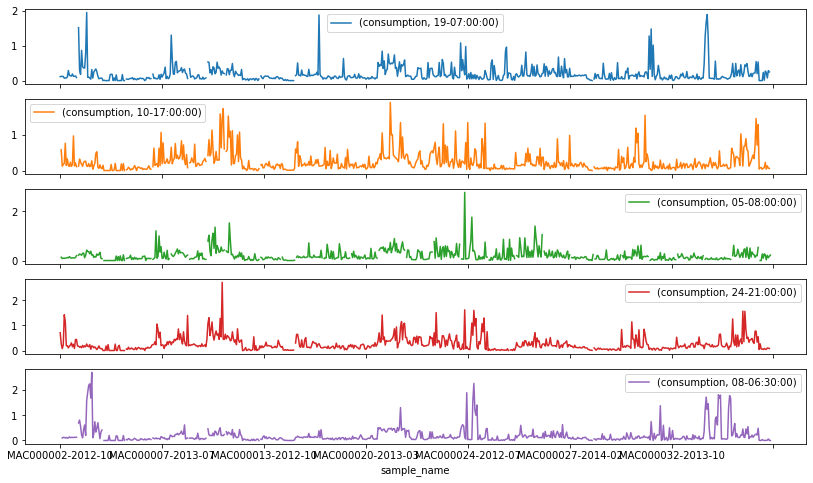

In [162]:
# Show some ranomd series
df_series.T.sample(5).T.plot( figsize = (14,8), subplots = True )
plt.show()

In [163]:
# synthetic dataset used to check columns ordering
# X = pd.concat([pd.Series([0]*10) for _ in range(10)] + [pd.Series([10]*10) for _ in range(2)], axis = 1)
# X.columns = [f'serie_{x}' for x in range(12)]
# X

In [165]:
# build config file to drive tsfel 

#cfg_file = tsfel.get_features_by_domain()               # All features will be extracted.
cgf_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
#cgf_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
#cgf_file = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted

In [166]:
# Xf is the feature extraction dataset from tsfel
# it is a single row of features with feature names in the format f'{s}_{name}' 
# where 's' is the column number in the original dataset and 'name' is the feature name.
# Feratures are orederd in alphabetical order thus features of column #11 come after 
# features of column #1
# This is beacuse tsfel is designed with multivariate ts in mind, not multiple ts.

Xf = tsfel.time_series_features_extractor(cfg_file, X ) 

*** Feature extraction started ***
16


/tmp/ipykernel_155792/3264033782.py:8: UserWarning: Using default sampling frequency set in configuration file.
  Xf = tsfel.time_series_features_extractor(cfg_file, X )



*** Feature extraction finished ***


In [167]:
Xf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 25128 entries, 0_ECDF Percentile Count_0 to 9_Variance
dtypes: float64(25128)
memory usage: 196.4 KB


In [168]:
# Convert the features row in a features table with time series in the rows and relevent features in the columns
df_features = ( Xf
  .T    # Transpose to have the columns as index
  .set_index( pd.MultiIndex.from_tuples( \
      [(int(i),s) for i,s in [re.match(r'(\d+)_(.+)',idx).groups() for idx in Xf.columns]]
   ))  # build a mulitindex from the current index
  .T   # Set the index back on the columns
  .stack(0)     # Level 0 of multiindex columns is the time series number in the order of the original dataset
  .droplevel(0) # index level 0 is just '0' because Xf had only one row
  .sort_index() # probably useless but there is noguarantee about column order from tsfel
  .set_index(X.columns) # rename the index as the names of the time series
)

In [170]:
df_features

,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,ECDF_2,ECDF_3,ECDF_4,ECDF_5,...,Max,Mean,Mean absolute deviation,Median,Median absolute deviation,Min,Root mean square,Skewness,Standard deviation,Variance
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,299.0,1196.0,0.000,0.307,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,2.160,0.185783,0.176096,0.117,0.117,0.0,0.309307,2.251715,0.247297,0.061156
MAC000002-2012-11,299.0,1196.0,0.103,0.289,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,1.714,0.230783,0.131420,0.185,0.075,0.0,0.308527,2.557183,0.204764,0.041928
MAC000002-2012-12,299.0,1196.0,0.104,0.293,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,1.692,0.237968,0.138218,0.167,0.072,0.0,0.318145,2.597335,0.211158,0.044588
MAC000002-2013-01,299.0,1196.0,0.109,0.278,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,1.603,0.240858,0.128409,0.196,0.077,0.0,0.321372,2.997614,0.212762,0.045268
MAC000002-2013-02,299.0,1196.0,0.088,0.288,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,2.994,0.255410,0.187892,0.162,0.078,0.0,0.399455,3.095023,0.307132,0.094330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000036-2012-07,299.0,1196.0,0.006,0.083,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,0.384,0.058311,0.042167,0.045,0.028,0.0,0.085560,1.994728,0.062613,0.003920
MAC000036-2012-08,299.0,1196.0,0.011,0.089,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,0.458,0.062924,0.043852,0.049,0.028,0.0,0.091358,2.116342,0.066232,0.004387
MAC000036-2012-09,299.0,1196.0,0.005,0.080,0.000669,0.001338,0.002007,0.002676,0.003344,0.004013,...,0.427,0.054996,0.040105,0.044,0.030,0.0,0.080496,2.041536,0.058780,0.003455


# Save ingested data

In [171]:
if isinstance( DATASET_ID, int )  :
    out_file_series = f'ingested/series_{DATASET_ID}.csv' 
    out_file_features = f'ingested/fsfel_features_{DATASET_ID}.csv' 
else :
    out_file_series = f'ingested/series_full_{DECIMATION_RATE}.csv' 
    out_file_features = f'ingested/fsfel_features_full_{DECIMATION_RATE}.csv' 
    
df_series.to_csv( dataset_root/out_file_series )
print(f'Series dataframe saved to {dataset_root/out_file_series}')

df_features.to_csv( dataset_root/out_file_features )
print(f'Features dataframe saved to {dataset_root/out_file_features}')


Series dataframe saved to ../../Dataset/ingested/series_0.csv
Features dataframe saved to ../../Dataset/ingested/fsfel_features_0.csv
